### Imports

In [2]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

PLOTS = True

### Load in Data and Normalize Scales

In [3]:
data = pd.read_csv("data/daily_ret_clean.csv").set_index("date")
stock_names = data.columns

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(data)

### Perform PCA

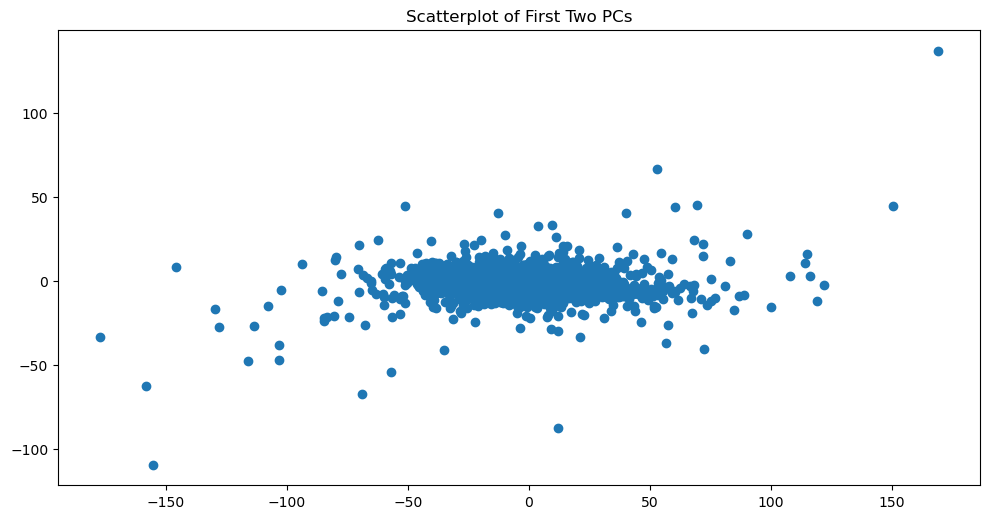

In [5]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(scaled)
combined = np.concatenate([pca.components_, pca.explained_variance_ratio_.reshape(-1,1)], axis=1)
components = pd.DataFrame(
    pca.components_,
    columns=list(stock_names),# + ["Explained Var"],
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

if PLOTS:
    #num_stocks = 5
    plt.figure(figsize=(10,10))
    #for i, pc in enumerate(components.index):
    #    plt.subplot(2,pca.n_components_,i+1)
    #    plt.bar(stock_names[:num_stocks], components.loc[pc].iloc[:num_stocks])
    #    plt.title(f"Feature Contributions to PC{i+1}")
    #    plt.ylabel("Loading Score")
    #    plt.xlabel("Features")

    plt.subplot(2,1,2)
    plt.title("Scatterplot of First Two PCs")
    plt.scatter(X_pca[:,0], X_pca[:, 1])

    plt.tight_layout()

### Portfolio Weighting
Your component mixtures are your portfolio weights

In [71]:
weights = components/data.std(axis=0)
factor_returns = weights.dot(data.T) / len(stock_names)
factor_returns

date,2000-01-03,2000-01-04,2000-01-05,2000-01-06,2000-01-07,2000-01-10,2000-01-11,2000-01-12,2000-01-13,2000-01-14,...,2023-12-15,2023-12-18,2023-12-19,2023-12-20,2023-12-21,2023-12-22,2023-12-26,2023-12-27,2023-12-28,2023-12-29
PC1,-0.013647,-0.024354,0.008191,0.004578,0.021617,0.007603,-0.011226,-0.002393,0.013517,0.004526,...,-0.009168,0.000361,0.014004,-0.016265,0.014025,0.005578,0.008910,0.000755,-0.000027,-0.007557
PC2,0.009475,0.007648,0.005283,0.004736,0.002122,-0.000328,-0.003665,-0.001158,-0.004137,-0.001905,...,0.000198,0.001264,0.000315,-0.000565,0.000022,0.000327,-0.001743,0.001430,-0.002139,0.003419
PC3,0.009265,-0.011001,-0.002980,-0.009936,0.007922,0.015203,-0.003805,-0.001819,0.005017,0.010294,...,0.003950,0.001310,-0.001192,-0.000571,0.003217,-0.000287,-0.000903,0.000129,-0.000502,0.002534
PC4,-0.005519,-0.005629,0.005347,-0.000991,0.010117,0.002154,-0.001245,0.000348,0.000731,-0.001717,...,-0.003867,0.001277,-0.002477,-0.004517,-0.000597,0.000913,-0.002118,0.000619,0.003427,0.003041
PC5,-0.007376,0.000470,0.005812,0.006950,0.002727,-0.007355,0.003782,-0.000323,0.001652,-0.002929,...,-0.000689,0.003488,0.000020,-0.002172,0.000325,-0.000163,-0.000144,-0.001485,-0.000633,0.001800


In [72]:
market_returns = np.mean(data, axis=1)
factor_returns.iloc[0].corr(market_returns)

0.9957797261714547

### Finding the Coefficients for Each Factor

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Sample data
X = factor_returns.T
Y = data

# Create a multi-output regression model
model = LinearRegression()
model.fit(X, Y)

coefs = pd.DataFrame(model.coef_, index=data.columns, columns=X.columns)
coefs["alpha"] = model.intercept_

coefs

,PC1,PC2,PC3,PC4,PC5,alpha
10026,0.677897,-0.115325,-0.455992,0.540137,-0.035943,0.000207
10032,1.201440,-0.830755,2.470060,-0.196432,-1.355554,0.000014
10044,0.309076,0.507966,0.070251,-0.257739,-0.145558,0.000371
10065,0.679103,0.186708,0.517480,0.312591,0.073116,-0.000197
10104,0.827907,-0.372503,1.918477,1.141431,-0.564237,-0.000087
...,...,...,...,...,...,...
90983,0.303922,0.394093,-0.417062,-0.542886,-0.109252,0.000433
91287,0.815815,0.487103,0.072117,-1.243717,-0.052719,0.000748
91556,0.783646,-0.200567,0.133245,0.452925,-0.480194,0.000384
92655,0.653097,0.529353,-0.132700,0.988607,0.568678,0.000368


This differs from a Fama-French style regression in that we don't have any external characteristics. In other words, we don't try to guess what the factors that impact the regression are. Instead, we purely try to estimate the factors from our returns. Interestingly, we actually manage to back out the CAPM market factor as shown by the high correlation of PC1 returns with the market.

### Simple Backtest

In [90]:
weights = coefs["alpha"]/(np.sqrt(coefs["alpha"]**2).sum()) * 1000
1 + (np.e ** data - 1) * weights

,10026,10032,10044,10065,10104,10107,10138,10145,10200,10207,...,88664,88912,89456,89858,89915,90983,91287,91556,92655,92690
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1.009361,0.999154,1.041184,1.002691,0.982181,1.000145,1.032339,1.010392,0.930998,0.992034,...,1.000560,1.019086,1.000536,1.007126,0.994608,1.027212,1.637783,0.956431,1.016042,1.002734
2000-01-04,0.938292,0.998679,1.023847,1.009410,1.027108,1.002993,1.020123,1.010574,1.000000,1.000000,...,0.962427,1.001917,1.000464,1.000000,0.981164,0.980224,0.563925,0.940379,0.982771,0.994635
2000-01-05,1.046541,0.999963,1.000000,1.005464,1.016490,0.999045,1.001238,1.008090,0.929604,0.997861,...,1.009834,0.990237,0.999755,1.015915,0.997210,1.006731,1.302299,1.032194,0.996810,1.000000
2000-01-06,1.002373,1.000074,0.881533,1.000000,1.018312,1.002969,0.979841,0.988191,1.073359,0.995750,...,0.995253,1.000000,1.000143,1.018729,1.028583,0.986679,0.948533,0.857278,1.050533,1.008327
2000-01-07,1.002366,1.000373,1.181518,0.997232,0.974404,0.998815,1.004807,0.966722,1.296403,1.004045,...,1.000000,1.016652,1.000263,1.003177,0.983940,1.000000,1.220170,0.982684,1.168727,0.997327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,1.005285,1.000320,1.012114,0.997100,0.998969,0.999749,0.993652,0.998258,1.012078,0.999362,...,1.005358,0.994067,1.000056,1.000000,1.009054,1.020423,1.000000,1.005620,1.001122,1.004825
2023-12-26,1.002916,1.000230,0.976239,0.993797,1.000030,0.999981,0.994974,0.992901,1.017397,0.999152,...,1.001400,0.994966,0.999887,1.001218,1.006491,1.000000,1.019459,1.006013,0.999271,1.004282
2023-12-27,0.995527,0.999422,0.978817,0.998774,1.000754,1.000142,1.000000,0.997145,1.001520,0.999156,...,0.993312,0.996476,0.999933,1.000242,1.003817,1.008990,1.019323,1.004230,1.007213,1.000936
